In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae352_quadrotor_new
import sympy as sym
import scipy.signal as signal
from control.matlab import ctrb
from scipy import linalg

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)
pi=np.pi

In [63]:
params = {
    'm': 0.249, #kg
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

In [64]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

In [65]:
#DEFINE EQUILIBRIUM
#f at equilibrium

#position\
(p_x_e, p_y_e, p_z_e) = (0,0,0)

#yaw, pitch, roll
(psi_e, theta_e, phi_e) = (0,0,0)

#linear velocity
(v_x_e, v_y_e, v_z_e) = (0,0,0)

#angular velocity
(w_x_e, w_y_e, w_z_e) = (0,0,0)

#net rotor torque
(tau_x_e, tau_y_e, tau_z_e) = (0,0,0)

#net rotor force
(f_z_e) = (m*9.81) #Net rotor force has to counteract gravity for equilibrium to be hover
print(f_z_e)

#f at equilibrium
f_e=f.subs({p_x:p_x_e, 
            p_y:p_y_e,
            p_z:p_z_e, #substituting values in f with equilibrium values
            psi:psi_e, 
            theta:theta_e,
            phi:phi_e,
            v_x:v_x_e, 
            v_y:v_y_e, 
            v_z:v_z_e,
            w_x:w_x_e, 
            w_y:w_y_e, 
            w_z:w_z_e,
            tau_x:tau_x_e, 
            tau_y:tau_y_e, 
            tau_z:tau_z_e,
            f_z:f_z_e})

f_e #f_e is all 0, so this equilibrium state works

4.90500000000000


Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [66]:
# Position of markers in body frame Acknowledgement to GRAYKS3248 Condynsate Template

p_in_world = sym.Matrix([p_x, p_y, p_z])

lxy=0.25 #x or y distance from quadrotor frame to markers in m CHANGE TO OUR MODEL DISTANCE
lz=0.046875 # The z distance from the quadrotor frame to the markers in m CHANGE TO OUR DISTANCE


mark1_inB = sym.Matrix([[lxy],
                        [0.],
                        [lz]])
mark2_inB = sym.Matrix([[0.],
                        [lxy],
                        [lz]])
mark3_inB = sym.Matrix([[-lxy],
                        [0.],
                        [lz]])
mark4_inB = sym.Matrix([[0.],
                        [-lxy],
                        [lz]])

# Position of markers in world frame
mark1_inW = p_in_world + R_body_in_world @ mark1_inB
mark2_inW = p_in_world + R_body_in_world @ mark2_inB
mark3_inW = p_in_world + R_body_in_world @ mark3_inB
mark4_inW = p_in_world + R_body_in_world @ mark4_inB

# Sensor model
g = sym.simplify(sym.Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))

g

Matrix([
[                                  p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) + 0.25*cos(psi)*cos(theta)],
[                                  p_y - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*sin(psi)*cos(theta)],
[                                                                                 p_z - 0.25*sin(theta) + 0.046875*cos(phi)*cos(theta)],
[p_x + 0.046875*sin(phi)*sin(psi) + 0.25*sin(phi)*sin(theta)*cos(psi) - 0.25*sin(psi)*cos(phi) + 0.046875*sin(theta)*cos(phi)*cos(psi)],
[p_y + 0.25*sin(phi)*sin(psi)*sin(theta) - 0.046875*sin(phi)*cos(psi) + 0.046875*sin(psi)*sin(theta)*cos(phi) + 0.25*cos(phi)*cos(psi)],
[                                                                        p_z + 0.25*sin(phi)*cos(theta) + 0.046875*cos(phi)*cos(theta)],
[                                  p_x + 0.046875*sin(phi)*sin(psi) + 0.046875*sin(theta)*cos(phi)*cos(psi) - 0.25*cos(psi)*cos(theta)],
[                               

In [67]:
#DEFINE EQUILIBRIUM

#g at equilibrium, equilibrium values defined from earlier

g_e=g.subs({p_x:p_x_e, 
            p_y:p_y_e,
            p_z:p_z_e,
            psi:psi_e, 
            theta:theta_e,
            phi:phi_e,
            v_x:v_x_e, 
            v_y:v_y_e, 
            v_z:v_z_e,
            w_x:w_x_e, 
            w_y:w_y_e, 
            w_z:w_z_e,})

g_e=np.array(g_e)
g_e

array([[0.250000000000000],
       [0],
       [0.0468750000000000],
       [0],
       [0.250000000000000],
       [0.0468750000000000],
       [-0.250000000000000],
       [0],
       [0.0468750000000000],
       [0],
       [-0.250000000000000],
       [0.0468750000000000]], dtype=object)

In [68]:
#FIND A AT EQUILIBRIUM

#lambdify to create numerical function, 
#then take jacobian of that wrt states
A_num=sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), f.jacobian([p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z])) 

A=A_num(p_x_e,p_y_e,p_z_e,psi_e,theta_e,phi_e,v_x_e,v_y_e,v_z_e,w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,tau_z_e,f_z_e) #plugging in equilibrium values into the new numerical equation
sym.Matrix(A)

Matrix([
[0, 0, 0, 0,    0,     0, 1.0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0, 1.0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0, 1.0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0, 1.0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0, 1.0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0, 1.0,   0,   0],
[0, 0, 0, 0, 9.81,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0, -9.81,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0]])

In [69]:
#FIND B AT EQULIBRIUM

B_num =  sym.lambdify((p_x, p_y, p_z,psi, theta, phi,v_x, v_y, v_z,w_x, w_y, w_z,tau_x, tau_y, tau_z, f_z), f.jacobian([tau_x, tau_y, tau_z, f_z]))

B = B_num(p_x_e, p_y_e, p_z_e, psi_e, theta_e, phi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
sym.Matrix(B)

Matrix([
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0,   0],
[               0,                0,     0, 2.0],
[434.782608695652,                0,     0,   0],
[               0, 434.782608695652,     0,   0],
[               0,                0, 250.0,   0]])

In [70]:
#FIND C

C_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), g.jacobian([p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z]))
#Jacobian wrt states, "Cx"

C = C_num(p_x_e,p_y_e,p_z_e,psi_e,theta_e,phi_e,v_x_e,v_y_e,v_z_e,w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,tau_z_e,f_z_e)

sym.Matrix(C)

Matrix([
[1.0,   0,   0,     0, 0.046875,         0, 0, 0, 0, 0, 0, 0],
[  0, 1.0,   0,  0.25,        0, -0.046875, 0, 0, 0, 0, 0, 0],
[  0,   0, 1.0,     0,    -0.25,         0, 0, 0, 0, 0, 0, 0],
[1.0,   0,   0, -0.25, 0.046875,         0, 0, 0, 0, 0, 0, 0],
[  0, 1.0,   0,     0,        0, -0.046875, 0, 0, 0, 0, 0, 0],
[  0,   0, 1.0,     0,        0,      0.25, 0, 0, 0, 0, 0, 0],
[1.0,   0,   0,     0, 0.046875,         0, 0, 0, 0, 0, 0, 0],
[  0, 1.0,   0, -0.25,        0, -0.046875, 0, 0, 0, 0, 0, 0],
[  0,   0, 1.0,     0,     0.25,         0, 0, 0, 0, 0, 0, 0],
[1.0,   0,   0,  0.25, 0.046875,         0, 0, 0, 0, 0, 0, 0],
[  0, 1.0,   0,     0,        0, -0.046875, 0, 0, 0, 0, 0, 0],
[  0,   0, 1.0,     0,        0,     -0.25, 0, 0, 0, 0, 0, 0]])

In [71]:
#FIND D 

D_num = sym.lambdify((p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z), g.jacobian([tau_x,tau_y,tau_z,f_z]))
#Jacobian wrt inputs, "Du"

D = D_num(p_x_e,p_y_e,p_z_e,psi_e,theta_e,phi_e,v_x_e,v_y_e,v_z_e,w_x_e,w_y_e,w_z_e,tau_x_e,tau_y_e,tau_z_e,f_z_e)

sym.Matrix(D)

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [72]:
#TEST CONTROLLABILITY

W = ctrb(A, B) #Controllability matrix
print(W)

rank_W = np.linalg.matrix_rank(W)
print(rank_W)
print(W.shape) #If the rank of the matrix equals its number of rows (or columns, whichever is smaller),
               #it is full rank and controllable
#It is controllable

[[    0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.         4265.2173913     0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.       ]
 [    0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.        -4265.2173913     0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.         

In [73]:
import control as ctrl

O = ctrl.obsv(A, C)  # Observability matrix

print(O)

Orank = np.linalg.matrix_rank(O)
print(Orank)
print(O.shape) #If the rank of the matrix equals its number of columns,
               #it is full rank and observable
#It is observable

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
12
(144, 12)


In [74]:
#LQR TO FIND K (FOR CONTROLLER)

def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = np.linalg.inv(R) @ B.T @ P
    return K

#Choose weights
# Q = np.diag([5, 5, 5, 90, 90, 90, 1, 1, 1, 1, 1, 1])
Q = np.diag([1, 1, 1, 90, 90, 90, 1, 1, 1, 1, 1, 1]) #Q VALUES FOR PERFORMANCE GOAL 3
R = np.diag([1000, 1000, 1000, 1])

K = lqr(A,B,Q,R)
sym.Matrix(K)

Matrix([
[1.63386839763082e-16,    -0.031622776601684, 6.76344224797433e-18, -2.34812305087316e-16, 2.80403208756622e-16,     0.386944664455861,  8.52263332238326e-17,   -0.0591155758761812,  6.46581948943966e-17,    0.0527251880650696, 2.83078525069763e-18, -5.93831228033283e-17],
[  0.0316227766016839,  1.16879032081557e-16, -2.3686896588718e-17,  8.94805293146758e-17,     0.38694466445586, -7.31706481234412e-17,    0.0591155758761811,  9.91097616999208e-17,  8.53574596812165e-18,  2.83078525069763e-18,   0.0527251880650697,  7.41530868957572e-19],
[1.59544891596057e-17,  6.19054531250023e-17,  -2.090730624157e-16,     0.300000000000001, 1.20221840265922e-16, -1.18891065648422e-15,  9.59687066062087e-17,  1.38741649098258e-16, -8.53900147186113e-17, -3.41452956119138e-17, 4.26380249650604e-19,    0.0583095189484532],
[1.65650056032705e-16, -1.83343802543643e-15,                  1.0, -4.01009479246535e-15, 5.38590798628947e-16,    7.981066223767e-15, -1.01735672455291e-15, -3.8163917

In [75]:
#CHECK A-BK REAL PARTS NEGATIVE

xdot=A-B@K

control_eig=np.linalg.eigvals(xdot)

control_eig #the optimized eigenvalues
#these are all real part neg so the system is stable

array([-10.57450325+4.2234094j , -10.57450325-4.2234094j ,
       -10.57450325+4.2234094j , -10.57450325-4.2234094j ,
        -7.28868987+4.67707173j,  -7.28868987-4.67707173j,
        -0.88749415+0.50261276j,  -0.88749415-0.50261276j,
        -0.88749415+0.50261276j,  -0.88749415-0.50261276j,
        -1.41421356+0.00000002j,  -1.41421356-0.00000002j])

In [76]:
#FIND L (FOR OBSERVER)

Q_L = np.identity(C.shape[0])
R_L = np.identity(A.shape[0])

Qinv = np.linalg.inv(Q_L)
Rinv = np.linalg.inv(R_L)

L = lqr(A.T, C.T, Rinv, Qinv).T
# L.shape
sym.Matrix(L)

Matrix([
[      1.6029062077909,  5.76325255504583e-16,    -0.190234588600967,       1.6029062077909,  6.22238868973664e-16,  7.93640832559165e-17,       1.6029062077909,  6.68152482442745e-16,     0.190234588600968,       1.6029062077909,  6.22238868973664e-16,  2.9087119536292e-16],
[ 6.57915658146586e-16,      1.60290620779089, -7.97342804207868e-16,  8.49756645680741e-16,      1.60290620779089,    -0.190234588600965,  6.57915658146586e-16,      1.60290620779089, -2.05283274256362e-16,  4.66074670612431e-16,      1.60290620779089,    0.190234588600964],
[ 1.89869723507198e-16,  -3.4228150361888e-16,     0.707106781186547,  7.71550361872114e-18, -5.24435723507356e-16,     0.707106781186547,  1.89869723507198e-16, -7.06589943395833e-16,     0.707106781186547,  3.72023943395674e-16, -5.24435723507356e-16,    0.707106781186547],
[-1.74585746243942e-16,      1.11803398874989,  6.80250438847869e-16,      -1.1180339887499, -8.39007440728174e-16,   1.1107154960422e-15, -1.74585746243942e-16

In [77]:
#CHECK A-LC REAL PARTS NEGATIVE

xdot_err=A-L@C
# print(xdot_err)

observe_eig=np.linalg.eigvals(xdot_err)
observe_eig #the optimized eigenvalues

#these are all real part neg so the system is detectable and asymptotically stable

xdot_err

array([[ -6.41162483,  -0.        ,  -0.        ,   0.        ,
         -0.39566221,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -0.        ,  -6.41162483,   0.        ,   0.        ,
         -0.        ,   0.39566221,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -0.        ,   0.        ,  -2.82842712,  -0.        ,
         -0.        ,  -0.        ,  -0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -0.        ,  -1.11803399,
          0.        ,  -0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   1.        ],
       [ -3.31276186,  -0.        ,  -0.        ,  -0.        ,
         -0.33462467,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,  -0.        ],
       [  0.        ,   3.31276186,

In [78]:
#UNCOMMENT EACH SECTION ONE AT A TIME FOR EACH PERFORMANCE GOAL. RECOMMENT THIS ONE BEFORE RUNNING NEXT
#PERFORMANCE GOAL 1
#Hover 1m above the ground for 2 minutes

# class Controller:
#     def __init__(self):

#         self.dt = 0.01

#         self.variables_to_log = ['x_hat', 'x_desired']

#         self.A = np.array(A, dtype=float)
#         self.B = np.array(B, dtype=float)
#         self.C = np.array(C, dtype=float)
#         self.K = np.array(K, dtype=float)
#         self.L = np.array(L, dtype=float)



#         self.tau_x_e = 0
#         self.tau_y_e = 0
#         self.tau_z_e = 0
#         self.f_z_e = 9.81*0.5

#     def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
#         self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
#         self.x_desired = np.zeros(12, dtype=float)

#     def run(self, **kwargs):

#         mocap1=kwargs['mocap_1']
#         mocap2=kwargs['mocap_2']
#         mocap3=kwargs['mocap_3']
#         mocap4=kwargs['mocap_4']
        
#         dt = kwargs.get('dt', 0.01)

#         pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
#                                 mocap2[0],mocap2[1],mocap2[2],
#                                 mocap3[0],mocap3[1],mocap3[2],
#                                 mocap4[0],mocap4[1],mocap4[2],])
        
#         x_desired = np.zeros(12)
#         pos = self.x_hat[0:3]
#         final_pos = np.array([0, 0, 1])

# # -----------------------------------------
#         #Hover at 1m above the ground
#         e_max = 0.01
    
#         if np.linalg.norm(final_pos - pos) > 0.1:
#             p_desired = pos + e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#         elif np.linalg.norm(final_pos - pos) > 0.05:
#             p_desired = pos + e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             v_desired = 0.05 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#         elif np.linalg.norm(final_pos - pos) > 0.01:
#             p_desired = pos + e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             v_desired = 0.007 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#         else:
#             p_desired = final_pos
#             v_desired = 0.001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
# # -----------------------------------------
        
#         x_desired[0:3] = p_desired
#         x_desired[6:9] = v_desired
#         self.x_desired = x_desired
    
#         u = -self.K @ (self.x_hat - self.x_desired)
    
#         y = pos_markers
    
#         self.x_hat += dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
    
#         tau_x = u[0]
#         tau_y = u[1]
#         tau_z = u[2]
#         f_z = u[3] + self.f_z_e
    
#         return tau_x, tau_y, tau_z, f_z

In [98]:
# #PERFORMANCE GOAL 2
# #Fly in a circle of radius 2m at an altitude of 1m above ground at speed of 0.5 m/s for at least 1 min

# class Controller:
#     def __init__(self):

#         self.dt = 0.01

#         self.variables_to_log = ['x_hat', 'x_desired']

#         self.A = A
#         self.B = B
#         self.C = C
#         self.K = K
#         self.L = L

#         self.tau_x_e = 0
#         self.tau_y_e = 0
#         self.tau_z_e = 0
#         self.f_z_e = 9.81*0.249
       
#         self.phase=0 #phase 0 - go to 1m altitude, phase 1 - go forward 2m, phase 2 - rotate around origin
#         self.theta=3*np.pi/2 #starting angle when rotation begins
  
#     def get_color(self):

#         return [
#             1. , # <-- how much red (between 0 and 1)
#             0., # <-- how much green (between 0 and 1)
#             0.25, # <-- how much blue (between 0 and 1)
#         ]

#     def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
#         self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
#         self.x_desired = np.zeros(12, dtype=float)

#     def run(self, **kwargs):

#         mocap1=kwargs['mocap_1']
#         mocap2=kwargs['mocap_2']
#         mocap3=kwargs['mocap_3']
#         mocap4=kwargs['mocap_4']
        
#         dt = kwargs.get('dt', 0.01)

#         pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
#                                 mocap2[0],mocap2[1],mocap2[2],
#                                 mocap3[0],mocap3[1],mocap3[2],
#                                 mocap4[0],mocap4[1],mocap4[2],])
        
#         x_desired = np.zeros(12)
#         pos = self.x_hat[0:3]

# # -----------------------------------------
#         #Getting the drone to 1m 

#         e_max = 0.01

#         if self.phase==0:
#             final_pos=np.array([0, 0, 1])
#             if np.linalg.norm(final_pos - pos) > 0.1:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             elif np.linalg.norm(final_pos-pos) > 0.05:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.05 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
#             elif np.linalg.norm(final_pos-pos) > 0.01:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.007 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))  

#             else:
#                 p_desired = final_pos
#                 v_desired = np.zeros(3)
#                 self.phase = 1
# # -----------------------------------------
#         #Have frone fly in circle of 2m at 0.5 m/s
        
#         elif self.phase==1:
#             radius=2
#             center=np.array([0,2,1])
#             speed=0.5

#             omega=speed/radius #angular velocity w=v/R

#             self.theta += omega*self.dt

#             self.theta = self.theta % (2*np.pi)

#             x=center[0]+radius*np.cos(self.theta)
#             y=center[1]+radius*np.sin(self.theta)

#             final_pos=np.array([x,y,1]) #altitude is constant

#             if np.linalg.norm(final_pos - pos) > 0.01:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos)) 
                
#             else:
#                 p_desired = final_pos
#                 v_desired = np.zeros(3)
# # -----------------------------------------
        
#         x_desired[0:3] = p_desired
#         x_desired[6:9] = v_desired
#         self.x_desired = x_desired

#         u = -self.K @ (self.x_hat - self.x_desired)

#         y = pos_markers

#         self.x_hat += self.dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
        
#         tau_x = u[0]
#         tau_y = u[1]
#         tau_z = u[2]
#         f_z = u[3] + self.f_z_e

#         return tau_x, tau_y, tau_z, f_z

In [120]:
# #PERFORMANCE GOAL 3 - No Yaw
# # up 1m, 5m at 1m/s, stop, yaw 90 deg left, 5m forward, land vertically < 0.01m/s speed
# #Uses different LQR values -- See comment in LQR Section

# class Controller:
#     def __init__(self):

#         self.dt = 0.01

#         self.variables_to_log = ['x_hat', 'x_desired']

#         self.A = A
#         self.B = B
#         self.C = C
#         self.K = K
#         self.L = L


#         self.tau_x_e = 0
#         self.tau_y_e = 0
#         self.tau_z_e = 0
#         self.f_z_e = 9.81*0.249
       
#         self.phase=0

    
#     def get_color(self):

#         return [
#             1. , # <-- how much red (between 0 and 1)
#             0., # <-- how much green (between 0 and 1)
#             0.25, # <-- how much blue (between 0 and 1)
#         ]

#     def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
#         self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
#         self.x_desired = np.zeros(12, dtype=float)


#         self.yaw_initial=yaw
        

#     def run(self, **kwargs):



#         mocap1=kwargs['mocap_1']
#         mocap2=kwargs['mocap_2']
#         mocap3=kwargs['mocap_3']
#         mocap4=kwargs['mocap_4']
        
#         dt = kwargs.get('dt', 0.01)


#         pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
#                                 mocap2[0],mocap2[1],mocap2[2],
#                                 mocap3[0],mocap3[1],mocap3[2],
#                                 mocap4[0],mocap4[1],mocap4[2],])
        
#         x_desired = np.zeros(12)
#         pos = self.x_hat[0:3]


#         p_desired = self.x_hat[0:3]
#         v_desired = np.zeros(3)

# # -----------------------------------------        
#         #Getting the drone to 1m 
        
#         e_max = 0.01

#         if self.phase==0:
#             final_pos=np.array([0, 0, 1])
#             if np.linalg.norm(final_pos - pos) > 0.1:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             elif np.linalg.norm(final_pos-pos) > 0.05:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.05 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
#             elif np.linalg.norm(final_pos-pos) > 0.01:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.007 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))  

#             else:
#                 p_desired = final_pos
#                 v_desired = np.zeros(3) 
#                 self.phase = 1
                
# # -----------------------------------------
#         #5m forward at 1 m/s
        
#         elif self.phase==1:
#             final_pos=np.array([0,5,1])
#             if np.linalg.norm(final_pos - pos) > 1.5:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 1 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             elif np.linalg.norm(final_pos-pos) > 1:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos)) 
#             elif np.linalg.norm(final_pos-pos) > 0.5:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.1 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
#             elif np.linalg.norm(final_pos-pos) > 0.3:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))   
#             else:
#                 p_desired = final_pos
#                 v_desired = 0.0001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 self.phase = 2

# # -----------------------------------------
#         #5m left
        
#         if self.phase==2:
#             final_pos=np.array([5, 5, 1])
#             if np.linalg.norm(final_pos - pos) > 1.5:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 1 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             elif np.linalg.norm(final_pos-pos) > 1:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos)) 
#             elif np.linalg.norm(final_pos-pos) > 0.5:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.1 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
#             elif np.linalg.norm(final_pos-pos) > 0.3:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             else:
#                 p_desired = final_pos
#                 v_desired = 0.0001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 self.phase = 3

# # -----------------------------------------
#         #Land vertically <0.01 m/s
        
#         if self.phase==3:
#             final_pos=np.array([5, 5, 0])
#             if np.linalg.norm(final_pos - pos) > 0.5:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.2 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#             elif np.linalg.norm(final_pos-pos) > 0.2:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.05 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
#             elif np.linalg.norm(final_pos-pos) > 0.001:
#                 p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
#                 v_desired = 0.001 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))  

#             else:
#                 p_desired = final_pos
#                 v_desired = np.zeros(3)
                
# # ----------------------------------------- 
        
#         x_desired[0:3] = p_desired
#         x_desired[6:9] = v_desired
#         self.x_desired = x_desired


        
#         u = -self.K @ (self.x_hat - self.x_desired)


        
#         y = pos_markers

        
#         self.x_hat += self.dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
        
#         tau_x = u[0]
#         tau_y = u[1]
#         tau_z = u[2]
#         f_z = u[3] + self.f_z_e


#         return tau_x, tau_y, tau_z, f_z


In [128]:
# # #PERFORMANCE GOAL 3 - Yaw, no linear
# # up 1m, 5m at 1m/s, stop, yaw 90 deg left, 5m forward, land vertically < 0.01m/s speed

class Controller:
    def __init__(self):

        self.dt = 0.01

        self.variables_to_log = ['x_hat', 'x_desired']

        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L


        self.tau_x_e = 0
        self.tau_y_e = 0
        self.tau_z_e = 0
        self.f_z_e = 9.81*0.249
       
        self.phase=0
    
    def get_color(self):

        return [
            1. , # <-- how much red (between 0 and 1)
            0., # <-- how much green (between 0 and 1)
            0.25, # <-- how much blue (between 0 and 1)
        ]

    def reset(self, p_x=0, p_y=0, p_z=0, yaw=0):
        self.x_hat = np.array([p_x, p_y, p_z, yaw, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float)
        self.x_desired = np.zeros(12, dtype=float)


        self.yaw_initial=yaw
        

    def run(self, **kwargs):

        mocap1=kwargs['mocap_1']
        mocap2=kwargs['mocap_2']
        mocap3=kwargs['mocap_3']
        mocap4=kwargs['mocap_4']
        
        dt = kwargs.get('dt', 0.01)


        pos_markers = np.array([mocap1[0],mocap1[1],mocap1[2],
                                mocap2[0],mocap2[1],mocap2[2],
                                mocap3[0],mocap3[1],mocap3[2],
                                mocap4[0],mocap4[1],mocap4[2],])
        
        x_desired = np.zeros(12)
        pos = self.x_hat[0:3]

        ori=self.x_hat[3:6]
        ori_desired=self.x_hat[3:6] #Yaw and hover works with this, position change doesn't
        w_desired = np.zeros(3)
        p_desired = self.x_hat[0:3]
        v_desired = np.zeros(3)

# ----------------------------------------- 
        #Getting the drone to 1m 
        
        e_max = 0.01

        if self.phase==0:
            final_pos=np.array([0, 0, 1])
            if np.linalg.norm(final_pos - pos) > 0.1:
                p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
                v_desired = 0.5 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
            elif np.linalg.norm(final_pos-pos) > 0.05:
                p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
                v_desired = 0.05 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))    
            elif np.linalg.norm(final_pos-pos) > 0.01:
                p_desired = pos +  e_max * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
                v_desired = 0.007 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))  

            else:
                p_desired = final_pos
                v_desired = np.zeros(3) 
                # v_desired = 0.007 * ((final_pos - pos) / np.linalg.norm(final_pos - pos))
                self.phase = 1

# ----------------------------------------- 
        #Yaw left

        elif self.phase==1: #yaw 90 deg left NOT WORKING YET
            yaw_desired=pi/2 #90 degrees
        
            yaw_change=self.x_hat[3]-self.yaw_initial
        
            final_ori=np.array([yaw_desired,0,0])
        
            e_ori=0.01

            if abs(yaw_change) < (pi/2):
                ori_desired = ori +  e_ori * ((final_ori - ori) / np.linalg.norm(final_ori - ori))
            else:              
                w_desired = np.zeros(3)
                self.phase=4 

# ----------------------------------------- 
        
        x_desired[0:3] = p_desired
        x_desired[6:9] = v_desired
        x_desired[3:6] = ori_desired
        x_desired[9:12] = w_desired
        self.x_desired = x_desired

        u = -self.K @ (self.x_hat - self.x_desired)

        y = pos_markers
        
        self.x_hat += self.dt * (self.A @ self.x_hat + self.B @ u - self.L @ (self.C @ self.x_hat - y))
        
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3] + self.f_z_e

        return tau_x, tau_y, tau_z, f_z

In [129]:
controller1=Controller()
team_list = [""]
sim = ae352_quadrotor_new.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    #visualization=True, #UNCOMMENT THIS AND COMMENT OUT BELOW TO RUN VISUALS
                                    visualization=False,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

In [130]:
controllers = [controller1]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.,
                              collect_data=True,
                              max_time=60*2.0, #change time based on performance goal
                              verbose=True) 

RESET


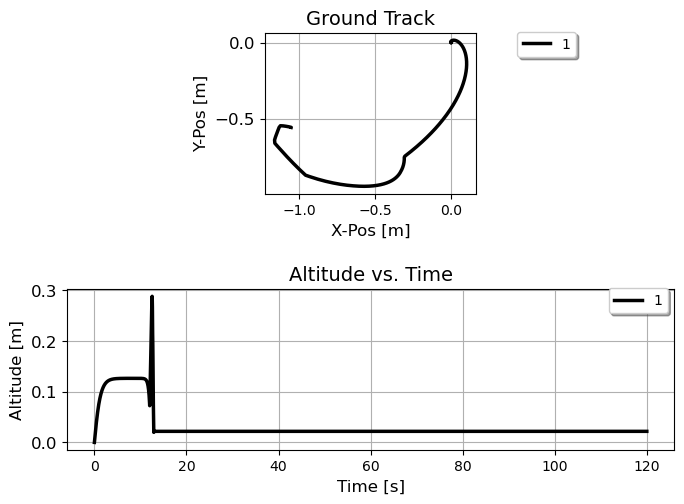

<Figure size 640x480 with 0 Axes>

In [131]:
# Create a figure that has two plots in it
import matplotlib.ticker as ticker
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
colors = ['k','r','g','b','m','c','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray']
for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])
    
    # Create a plot of the ground path of the quadrotor
    axes[0].plot(pos[:,0], pos[:,1], c=colors[i], lw=2.5, label=str(i+1))
    
    # Create a plot of the altitude versus time
    axes[1].plot(data[0]['time'], pos[:,2], c=colors[i], lw=2.5, label=str(i+1))

# Make plot 0 pretty
axes[0].set_xlabel("X-Pos [m]", fontsize=12)
axes[0].set_ylabel("Y-Pos [m]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Altitude [m]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()
plt.savefig('ground_track_sim_3_2.png')

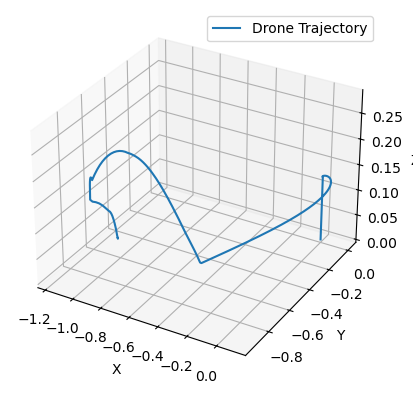

<Figure size 640x480 with 0 Axes>

In [132]:
# TRAJECTORY TRACKING

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])

    drone_x = pos[:,0]
    drone_y = pos[:,1]
    drone_z = pos[:,2]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot3D(drone_x, drone_y, drone_z, label='Drone Trajectory')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()
plt.savefig('3d-graph_sim_3_2.png')

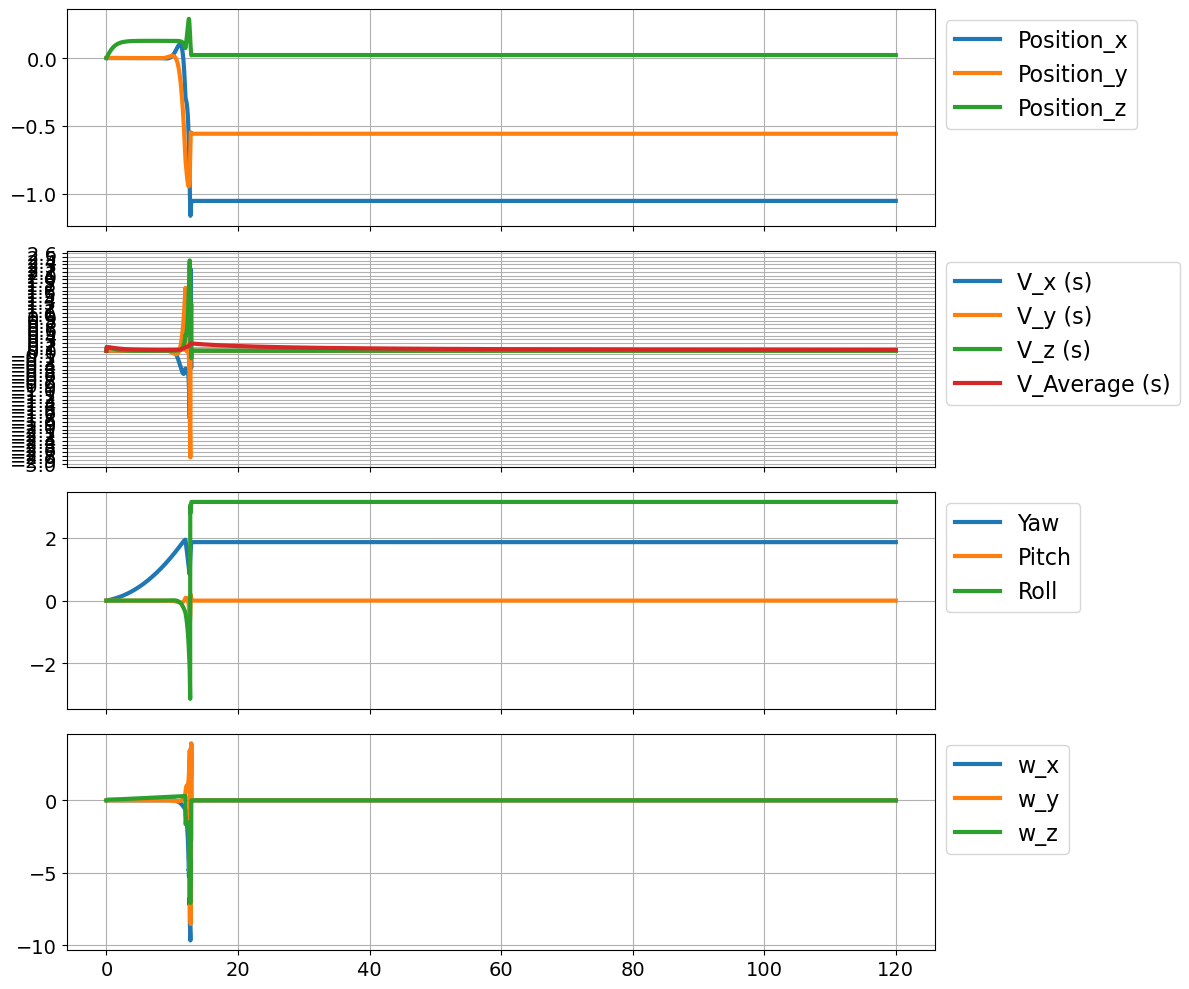

In [133]:
import matplotlib.ticker as ticker

fig, (ax_pos, ax_vel, ax_ori, ax_ang) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# -----------------------------------------

# Position

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    pos = np.array(data[i]['position'])

    p_x = pos[:,0]
    p_y = pos[:,1]
    p_z = pos[:,2]

ax_pos.plot(t, p_x, label='Position_x', linewidth=3, color='C0')
ax_pos.plot(t, p_y, label='Position_y', linewidth=3, color='C1')
ax_pos.plot(t, p_z, label='Position_z', linewidth=3, color='C2')

ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# -----------------------------------------

# Velocity

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    vel = np.array(data[i]['velocity'])

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]

    v_mag = np.sqrt(v_x**2 + v_y**2 + v_z**2)
    v_avg = np.cumsum(v_mag) / np.arange(1, len(v_mag)+1)

ax_vel.plot(t, v_x, label='V_x (s)', linewidth=3, color='C0')
ax_vel.plot(t, v_y, label='V_y (s)', linewidth=3, color='C1')
ax_vel.plot(t, v_z, label='V_z (s)', linewidth=3, color='C2')
ax_vel.plot(t, v_avg, label='V_Average (s)', linewidth=3, color='C3')
ax_vel.grid()
ax_vel.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
ax_vel.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_vel.tick_params(labelsize=14)

# -----------------------------------------

# Orientation

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    ori = np.array(data[i]['orientation'])

    yaw = ori[:,0]
    pitch = ori[:,1]
    roll = ori[:,2]

ax_ori.plot(t, yaw, label='Yaw', linewidth=3, color='C0')
ax_ori.plot(t, pitch, label='Pitch', linewidth=3, color='C1')
ax_ori.plot(t, roll, label='Roll', linewidth=3, color='C2')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)
fig.tight_layout()

# -----------------------------------------

#Angular Velocity

for i in range(len(data)):
    
    t = np.array(data[i]['time'])
    
    ang = np.array(data[i]['angular velocity'])

    ang_x = ang[:,0]
    ang_y = ang[:,1]
    ang_z = ang[:,2]

ax_ang.plot(t, ang_x, label='w_x', linewidth=3, color='C0')
ax_ang.plot(t, ang_y, label='w_y', linewidth=3, color='C1')
ax_ang.plot(t, ang_z, label='w_z', linewidth=3, color='C2')
ax_ang.grid()
ax_ang.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ang.tick_params(labelsize=14)
fig.tight_layout()
plt.show()

In [134]:
plt.savefig('all_data_sim_3_2.png')

<Figure size 640x480 with 0 Axes>